In [1]:
import numpy as np
import matplotlib.pyplot as plt


import chess
import gym

# gym-chess library=bad

In [24]:
import gym
import gym_chess
env = gym.make('ChessVsRandomBot-v0')
env.render(mode='human')
moves = env.get_possible_moves(env.state, 1)
# m = random.choice(moves)
# action = env.move_to_actions(m)

# actions
actions = env.get_possible_actions(env.state, 1)
# action = random.choice(actions)


    -------------------------
 8 |  ♖  .  .  .  ♔  .  .  ♖ |
 7 |  ♙  .  .  .  .  .  .  ♙ |
 6 |  .  .  .  .  .  .  .  . |
 5 |  .  .  .  .  .  .  .  . |
 4 |  .  .  .  .  .  .  .  . |
 3 |  .  .  .  .  .  .  .  . |
 2 |  ♟  .  .  .  .  .  .  ♟ |
 1 |  ♜  .  .  .  ♚  .  .  ♜ |
    -------------------------
      a  b  c  d  e  f  g  h 



/home/akarshkumar0101/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'gym_chess.envs.chess.ChessEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Python-chess = good

. . b q k b . r
. P p p . . . p
. . . . p . . .
. . . . . . . .
. . P n . p p .
. . . . . . . .
P . Q . P P P P
R N B . K B N R


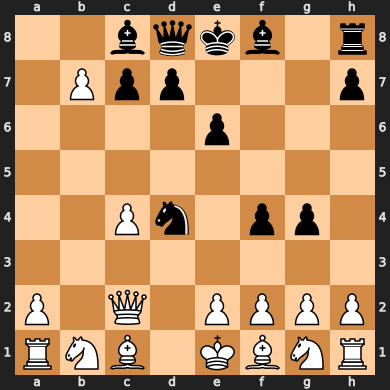

In [68]:
board = chess.Board()
# board.push_san('b1c3')
# board.push_san('b8c6')
# board.push_san('b2b3')
# board.push_san('e7e5')
# board.push_san('c1b2')
# print(board.board_fen())
board.set_board_fen('2bqkb1r/1Ppp3p/4p3/8/2Pn1pp1/8/P1Q1PPPP/RNB1KBNR')


print(board)
board

In [83]:
for move in list(board.legal_moves):
    if move.from_square == chess.B7:
        print(move)

b7c8q
b7c8r
b7c8b
b7c8n
b7b8q
b7b8r
b7b8b
b7b8n


In [3]:
def uint64_to_uint8(a):
    ans = []
    for i in range(8):
        ans.append((a & (255<<(i*8)))>>(i*8))
    ans.reverse()
    return np.array(ans, dtype=np.uint8)

def get_representation(board):
    rep = []
    for player in [True, False]:
        for piece in range(1, 7):
            bitint = board.pieces_mask(piece, player)
            bitmask = np.unpackbits(uint64_to_uint8(bitint)[..., None], axis=-1).astype(bool)
            bitmask = np.flip(bitmask, axis=[0,1])
            rep.append(bitmask)
    return np.array(rep)

(12, 8, 8)
bool


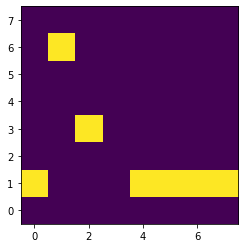

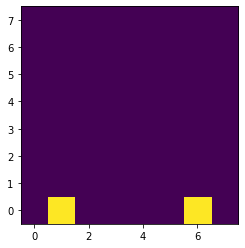

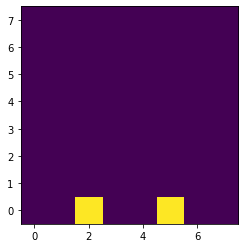

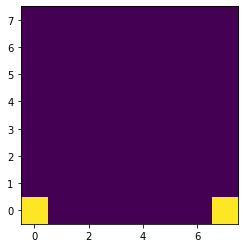

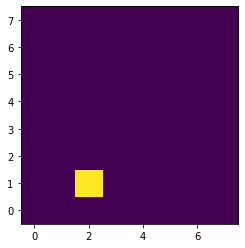

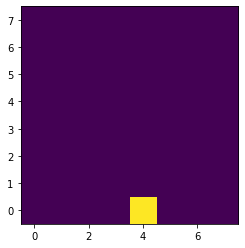

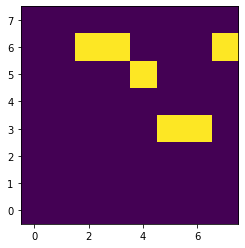

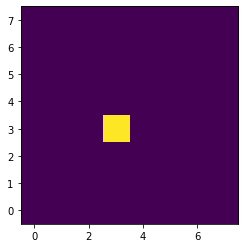

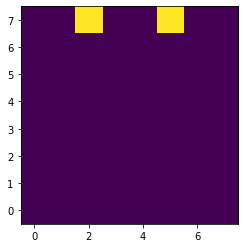

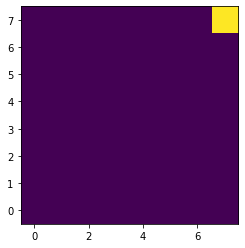

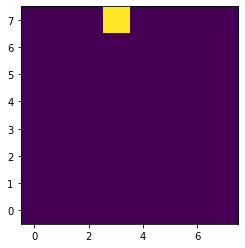

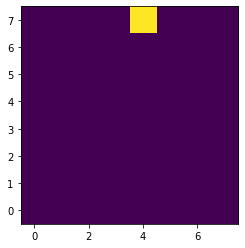

In [84]:

rep = get_representation(board)
print(rep.shape)
print(rep.dtype)

i=0
for player in [True, False]:
    for piece in range(1, 7):
        plt.imshow(rep[i])
        plt.ylim(-.5, 7.5)
        plt.show()
        i+=1


In [5]:
import torch

In [59]:
def get_conv_block(in_channels):
    conv = torch.nn.Conv2d(in_channels, 256, (3, 3), 1, padding=1)
    bn = torch.nn.BatchNorm2d(256)
    relu = torch.nn.ReLU()
    return torch.nn.Sequential(*[conv, bn, relu])

class ResidualBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(256, 256, (3, 3), 1, padding=1)
        self.bn = torch.nn.BatchNorm2d(256)
        self.conv2 = torch.nn.Conv2d(256, 256, (3, 3), 1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(256)
    
    def forward(self, X):
        O = self.conv(X)
        O = self.bn(O)
        O = torch.relu(O)
        O = self.conv2(O)
        O = self.bn2(O)
        O = O + X
        O = torch.relu(O)
        return O
    
class ResidualTower(torch.nn.Module):
    def __init__(self, in_channels, num_res_blocks):
        super().__init__()
        self.conv_block = get_conv_block(in_channels)
        self.res_blocks = torch.nn.Sequential(*[ResidualBlock() for i in range(num_res_blocks)])
    
    def forward(self, X):
        O = self.conv_block(X)
        O = self.res_blocks(O)
        return O

# These are custom modules not in the paper's definitions
class PolicyHead(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(256, 73, (3, 3), 1, padding=1)
        self.bn = torch.nn.BatchNorm2d(73)
        
        
        self.conv1 = torch.nn.Conv2d(256, 128, (3, 3), 1)
        self.bn1 = torch.nn.BatchNorm2d(128)
        self.conv2 = torch.nn.Conv2d(128, 64, (3, 3), 1)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.conv3 = torch.nn.Conv2d(64, 32, (3, 3), 1)
        self.bn3 = torch.nn.BatchNorm2d(32)
        self.conv4 = torch.nn.Conv2d(32, 16, (1, 1), 1)
        self.bn4 = torch.nn.BatchNorm2d(16)
        
        self.fc1 = torch.nn.Linear(16*2*2, 16*2*2)
        self.fc2 = torch.nn.Linear(16*2*2, 16*2*2)
        self.fc3 = torch.nn.Linear(16*2*2, 73*8*8)
       
    def forward(self, X):
        # in: [B, 256, 8, 8]
        
        O1 = torch.relu(self.bn(self.conv(X)))
        
        
        O2 = torch.relu(self.bn1(self.conv1(X)))
        O2 = torch.relu(self.bn2(self.conv2(O2)))
        O2 = torch.relu(self.bn3(self.conv3(O2)))
        O2 = torch.relu(self.bn4(self.conv4(O2)))
        print(O2.shape)
        O2 = O2.view(O2.shape[0], -1)
        print(O2.shape)
        O2 = torch.relu(self.fc1(O2))
        O2 = torch.relu(self.fc2(O2))
        O2 = torch.relu(self.fc3(O2))
        O2 = O2.view(O2.shape[0], 73, 8, 8)
        O = torch.relu(O1+O2)
        return O
    
    
def get_value_head():
    conv = torch.nn.Conv2d(in_channels, 1, (1, 1), 1)
    bn = torch.nn.BatchNorm2d(1)
    relu = torch.nn.ReLU()
    torch.nn.Flatten()
    fc = torch.nn.Linear(1, 256)
    torch.nn.ReLU()
    fc = torch.nn.Linear(1, 1)
    torch.nn.Tanh()
    

class ChessNet(torch.nn.Module):
    def __init__(self, num_res_blocks, M=14, T=8, L=7):
        super().__init__()
        self.res_tower = ResidualTower(M*T+L, num_res_blocks)
        
        # [1, 256, 8, 8]
        
        self.policy_head = PolicyHead()
#         self.value_head = get_value_head()
        
    
    def forward(self, X):
        # X.shape = (1, 119, 8, 8)
        
        O = self.res_tower(X)
        
        P = self.policy_head(O)
        
        # O.shape = (8, 8, 73)
        return P
    
    
chess_net = ChessNet(5)

chess_net(torch.randn(1, 119, 8,8)).shape

torch.Size([1, 16, 2, 2])
torch.Size([1, 64])


torch.Size([1, 73, 8, 8])

In [47]:
73*8*8*100

467200

In [63]:
"""
`z` is the game outcome (B, )
`v` is the nn prediction of game (B, )
`mcts_p` it the monte carlo tree search policy found (B, A)
`nn_p` it the nn policy evaluated (B, A)
"""
def loss_func(z, v, mcts_p, nn_p):
    return (z-v)**2 - (mcts_p*torch.log(nn_p)).sum(dim=-1)

In [4]:
for epoch_idx in range(1):
    print(f'EPOCH: {epoch_idx}')
    # Play a game
    board = init_board()
    
    while True:
        
    
    # Update parameters

EPOCH: 0


In [ ]:
def get_actions_policy(node):
    state, N, W, P, actions = node
    
    actions = get_legal_actions(state)
    P = mask_legal(nn(state))
    
    return state, N, W, P, actions
    

def MTCS(state, num_sim):
    node = (state, 0, 0, None, None) # (state, N, W, P, actions)
    node = get_actions_policy(node)
    
    
    pass

def MTCS_one_sim(state, depth):
    pass

In [ ]:
(state, N, W, P, map<action, obj>)